<a href="https://colab.research.google.com/github/ChenYP-1982/SentimentPR1/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando dependendcias

In [66]:
%%capture
!pip install sidetable


# Importando dependências


In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
from tqdm.notebook import tqdm




import nltk
from nltk.tokenize import TweetTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,)



from scipy.special import softmax


import warnings

warnings.filterwarnings("ignore")

# Funcões necessárias para o trabalho


In [68]:
def eda(df:pd.DataFrame):
  '''
  Retornara um analise exploratoria simples

  -param df: pandas dataframe
  '''
  print("-"*30,"DataFrame Shape", "-"*30)
  print(df.shape)
  print("-"*30,"DataFrame info", "-"*30)
  print(df.info())
  print("-"*30,"DataFrame Nan", "-"*30)
  print(df.isna().sum())
  print("-"*30,"DataFrame duplicated", "-"*30)
  print(df.duplicated().sum())
  print("-"*30,"DataFrame nunique", "-"*30)
  print(df.nunique())


def date_engineering(df:pd.DataFrame)->pd.DataFrame:
  '''
  Retorna um pandas dataframe novo com colunas adicionais como mes, dia da semana,
  trimestre, ano, mes
  -param df: pandas dataframe
  '''
  df["month"]=df["date"].dt.month
  df["day_week"]=df["date"].dt.dayofweek
  df["quarter"]=df["date"].dt.quarter
  df["year"]=df["date"].dt.year
  df["month"]=df["date"].dt.month
  return df

In [79]:
#dataset contendo alguns erros
df=pd.read_csv("/content/Reviews.csv",encoding='utf-8',engine='python',error_bad_lines=False, sep=",")

In [80]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [81]:
eda(df)

------------------------------ DataFrame Shape ------------------------------
(568454, 10)
------------------------------ DataFrame info ------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
-----------------------------

In [72]:

#transformando a coluna TIME em datetime[ns]
df["date"]=pd.to_datetime(df.Time, unit='s')
df1=df.sort_values(by="date", ascending=True).copy()


In [73]:
#criando colunas adicionais para date
df1=date_engineering(df1)
df1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08,10,4,4,1999
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25,10,0,4,1999
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02,12,3,4,1999
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999


In [101]:
df1["Summary"][150500]

'This whole series is great way to spend time with your child'

In [105]:
df1.loc[(df1["UserId"]=="A3TVZM3ZIXG8YW")]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
426315,426316,B003BJOORW,A3TVZM3ZIXG8YW,christopher hayes,33,48,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
96897,96898,B003WK0D8O,A3TVZM3ZIXG8YW,christopher hayes,6,15,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
369795,369796,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,11,15,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
247051,247052,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,18,24,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
145025,145026,B003MA8P02,A3TVZM3ZIXG8YW,christopher hayes,6,15,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354443,354444,B001VIY8BW,A3TVZM3ZIXG8YW,christopher hayes,2,4,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
489993,489994,B002Z9EQQ8,A3TVZM3ZIXG8YW,christopher hayes,7,11,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
247110,247111,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,2,4,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010
354389,354390,B001VIY8BW,A3TVZM3ZIXG8YW,christopher hayes,3,3,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",2010-12-04,12,5,4,2010


# Data understanding

### Padrao por Usuario

In [98]:
#temos 1 cliente dos top 20 clientes que mais escreveram Reviews  que classificou todos
#os produtos que ele comprou como nota 1
 (df1.groupby("UserId").
 agg(qtd_reviews=("Text","count"),
     resumo=("Summary","nunique"),
     media_score=("Score","mean")).
 sort_values("qtd_reviews", ascending=False)
 .head(20))

,qtd_reviews,resumo,media_score
UserId,,,
A3OXHLG6DIBRW8,448,259,4.535714
A1YUL9PCJR3JTY,421,198,4.494062
AY12DBB0U420B,389,325,4.647815
A281NPSIMI1C2R,365,249,4.841096
A1Z54EM24Y40LL,256,187,4.453125
A1TMAVN4CEM8U8,204,44,4.833333
A2MUGFV2TDQ47K,201,160,3.751244
A3TVZM3ZIXG8YW,199,1,1.000000
A3PJZ8TU8FDQ1K,178,70,4.601124


# Entendimento sobre notas

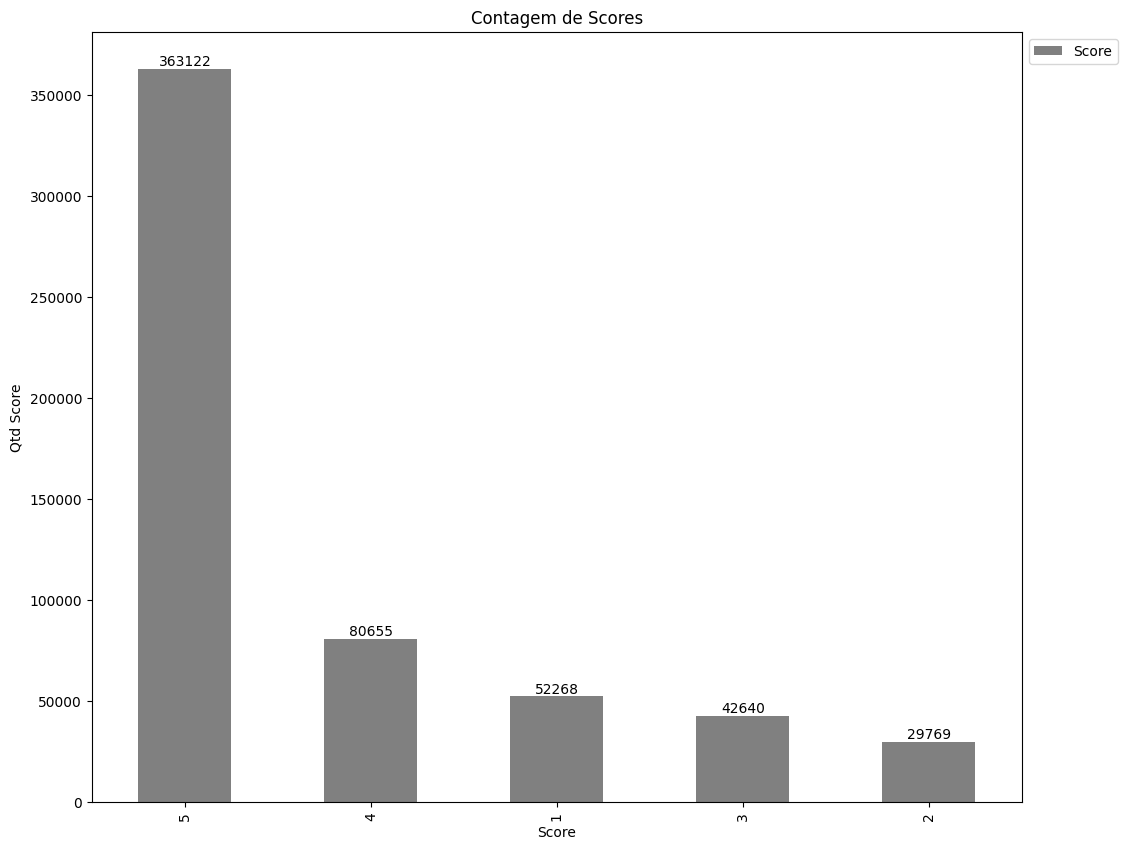

In [126]:
ax=df1["Score"].value_counts().plot(kind="bar",figsize=(12,10), color="gray")
ax.set_xlabel("Score")
ax.set_ylabel("Qtd Score")
ax.set_title("Contagem de Scores")
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# NLTK

In [131]:
df1.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08,10,4,4,1999
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25,10,0,4,1999
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02,12,3,4,1999
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451877,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06,12,0,4,1999
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,2000-01-03,1,0,1,2000
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,2000-01-09,1,6,1,2000
451948,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,2000-01-09,1,6,1,2000
230347,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,2000-01-09,1,6,1,2000


In [145]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [141]:
#retirando um review para servir de baseline
test=df1["Text"][50]
test

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [156]:
#testando word_tokenize
[x.replace("'", '') for x in nltk.word_tokenize(test)]

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 'nt',
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [157]:
tweet=TweetTokenizer()
test_token=[x.replace("'", '') for x in tweet.tokenize(test)]
test_token

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'dont',
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [160]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [161]:
sia=SentimentIntensityAnalyzer()

## Testando como sao feitos o polarity_scores

In [164]:
#entendendo como sao classificados em negm neutro, positivo e compound
sia.polarity_scores("Lets go sleep")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [165]:
sia.polarity_scores("Roman Emprire is falling!!!")

{'neg': 0.452, 'neu': 0.548, 'pos': 0.0, 'compound': -0.3561}

In [173]:
sia.polarity_scores("You are a good badass!!!")

{'neg': 0.217, 'neu': 0.271, 'pos': 0.512, 'compound': 0.4898}

In [175]:
#testando como o polarity test entende o texto test
test, sia.polarity_scores(test)


("This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.",
 {'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448})

In [185]:
# iterando todo meu data set, testando primeiro com sample de 1000 linhas para reduzir o custo computacional

df_test=df1.sample(n=1000)
result={}
for i, row in tqdm(df_test.iterrows(),total=len(df_test) ):
  text=row["Text"]
  myId=row["Id"]
  result[myId]=sia.polarity_scores(text)





  0%|          | 0/1000 [00:00<?, ?it/s]

In [192]:
#transformando em pandasdataframe
sentiment=pd.DataFrame(result).T
sentiment.columns=["vader_neg", "vader_neu", "vader_pos","vader_compound"]
sentiment

,vader_neg,vader_neu,vader_pos,vader_compound
285811,0.022,0.751,0.226,0.9511
172159,0.000,0.836,0.164,0.7100
524218,0.032,0.766,0.202,0.9075
556211,0.176,0.824,0.000,-0.5399
310679,0.000,0.828,0.172,0.7003
...,...,...,...,...
523566,0.000,0.701,0.299,0.8268
119682,0.069,0.847,0.084,0.4342
227689,0.185,0.710,0.105,-0.3365
92353,0.299,0.632,0.069,-0.8115


In [195]:
df_test

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year
285810,285811,B00269FEIG,A715IFJE96H96,S. Archer,0,0,4,1309132800,"Excellent muesli, if a little expensive.",This muesli is one of the best available. In f...,2011-06-27,6,0,2,2011
172158,172159,B004CHB4WK,A3NN5C9JEVKPKP,Durpabiscuit,0,0,5,1347667200,Kit Kat Big Kat,OM NOM NOM NOM NOM<br /><br />These things are...,2012-09-15,9,5,3,2012
524217,524218,B004JGQ15E,A1SD1C8XK3Z3V1,"William V. Hayes ""guitfiddleblue""",0,1,5,1304035200,sumptuous treat... healthy to eat,I don't like long reviews... and this is a sim...,2011-04-29,4,4,2,2011
556210,556211,B004EDZ87Y,A3NWJPIRABJXX3,Priscilla A. Smith,0,0,4,1300665600,Tasty Chai tea,I was skeptical thinking this tea might not ha...,2011-03-21,3,0,1,2011
310678,310679,B000ORY230,A2I34VMAQ0W3PQ,"nurse S ""avid reader""",0,0,5,1289865600,great vitamin for kids,My son's Doctor has him on these. The have a ...,2010-11-16,11,1,4,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523565,523566,B001SATWUA,AH8HSBRNDCQYD,lokilada,1,1,5,1317772800,Great Quality for the price,Decided to try out this coffee because it was ...,2011-10-05,10,2,4,2011
119681,119682,B006O02832,A17V9XL4CWTQ6G,Chandler,5,5,5,1332892800,Addictive garlic but peeled is better to buy t...,Update 5/4:<br />Culinary Elite brand on Amazo...,2012-03-28,3,2,1,2012
227688,227689,B001FSJCPK,A383SWBQO9VMFC,"Jonathan T. Henderson ""Tom Henderson""",0,0,5,1350950400,unique product,I couldn't get our cat to take her medicine an...,2012-10-23,10,1,4,2012
92352,92353,B007TGDXMK,#oc-R1HM2SQ1WTDKM1,J. Voss,0,4,1,1337385600,Tastes like Dish water,This coffee tastes like dish water! Smells hor...,2012-05-19,5,5,2,2012


In [202]:
df_sentiment=pd.merge(df_test, sentiment.reset_index().rename(columns={"index":"Id"}), how="left", on="Id")
df_sentiment.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,month,day_week,quarter,year,vader_neg,vader_neu,vader_pos,vader_compound
0,285811,B00269FEIG,A715IFJE96H96,S. Archer,0,0,4,1309132800,"Excellent muesli, if a little expensive.",This muesli is one of the best available. In f...,2011-06-27,6,0,2,2011,0.022,0.751,0.226,0.9511
1,172159,B004CHB4WK,A3NN5C9JEVKPKP,Durpabiscuit,0,0,5,1347667200,Kit Kat Big Kat,OM NOM NOM NOM NOM<br /><br />These things are...,2012-09-15,9,5,3,2012,0.000,0.836,0.164,0.7100
2,524218,B004JGQ15E,A1SD1C8XK3Z3V1,"William V. Hayes ""guitfiddleblue""",0,1,5,1304035200,sumptuous treat... healthy to eat,I don't like long reviews... and this is a sim...,2011-04-29,4,4,2,2011,0.032,0.766,0.202,0.9075
3,556211,B004EDZ87Y,A3NWJPIRABJXX3,Priscilla A. Smith,0,0,4,1300665600,Tasty Chai tea,I was skeptical thinking this tea might not ha...,2011-03-21,3,0,1,2011,0.176,0.824,0.000,-0.5399
4,310679,B000ORY230,A2I34VMAQ0W3PQ,"nurse S ""avid reader""",0,0,5,1289865600,great vitamin for kids,My son's Doctor has him on these. The have a ...,2010-11-16,11,1,4,2010,0.000,0.828,0.172,0.7003


In [205]:
df_sentiment["Text"][3]

'I was skeptical thinking this tea might not have a bold enough flavor.  It is instead very flavorful with just the right amount of spice.'